In [5]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-5-777961066ac7>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Using device cuda:0


In [7]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [8]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=NORM_MEAN,
    #                      std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        # img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        # adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

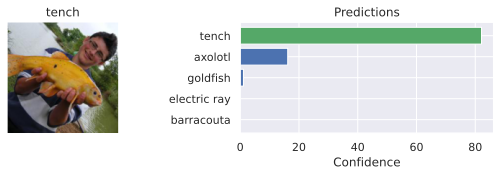

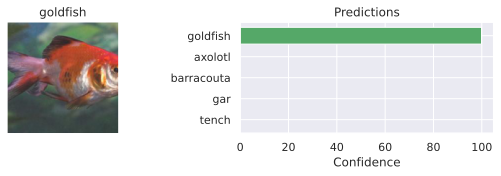

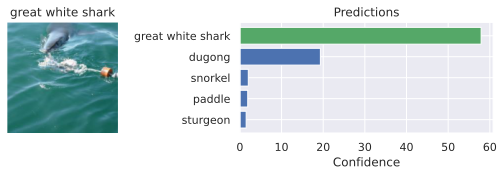

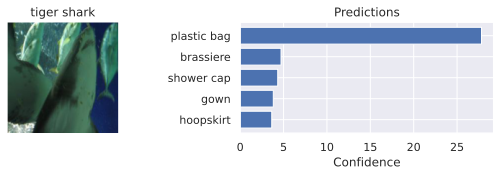

In [12]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [13]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

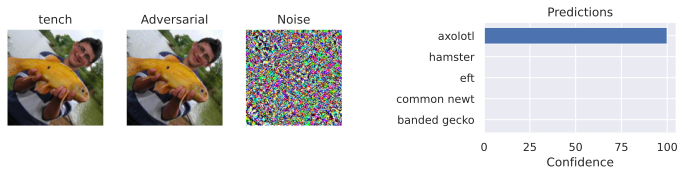

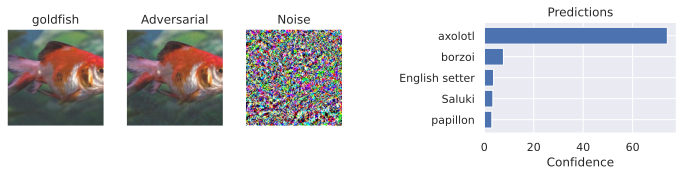

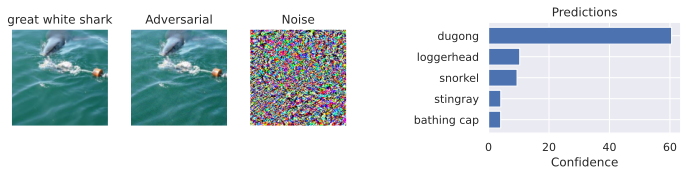

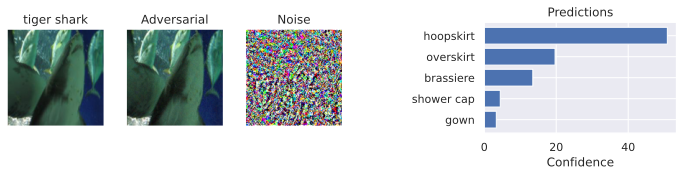

In [14]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [15]:
_ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Top-1 error: 99.12%
Top-5 error: 92.60%


In [24]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import transforms, datasets, models
from torchvision.transforms import ToTensor
import cv2
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder


from tqdm.auto import tqdm

In [2]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Resizing the images to 30x30x3
IMG_HEIGHT = 224
IMG_WIDTH = 244
channels = 3

In [4]:
from torch.utils.data import random_split
from collections import Counter
mean = [0.3374, 0.3096, 0.3209]
std = [0.2723, 0.2628, 0.2723]
transform = transforms.Compose([
            transforms.Resize((IMG_HEIGHT,IMG_WIDTH)),
            transforms.ToTensor(),
            # transforms.Normalize(mean,std)
            ])
transform2 = transforms.Compose([
            transforms.Resize((IMG_HEIGHT,IMG_WIDTH)),
            transforms.ToTensor(),
            # transforms.Normalize(mean,std)
            ])

In [5]:
d = torchvision.datasets.GTSRB(root= '.', split= 'train', transform = transform, download= True)
test_ds = torchvision.datasets.GTSRB(root= '.', split= 'test',transform = transform2, download= True)

In [6]:

random_seed = 42
torch.manual_seed(random_seed);
val_size = int(0.2*len(d))
train_size = int(len(d)-val_size)
train_ds, val_ds = random_split(d, [train_size, val_size])


train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=8, num_workers=2,shuffle=True)

val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=16, shuffle=True, num_workers=2)


test_dl = torch.utils.data.DataLoader(test_ds,
    batch_size=32, shuffle=True, num_workers=4)

In [7]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(28, 28))
        ax.set_xticks([]); ax.set_yticks([])
        # ax.imshow(make_grid(to_device(transforms.Normalize(-np.array(mean)/std, 1.0/np.array(std))(images),"cpu"), nrow=16).permute(1, 2, 0)) ##denormalize
        ax.imshow(make_grid(to_device(images,"cpu"), nrow=16).permute(1, 2, 0)) ##denormalize
        break

In [8]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader(): #wrap a dataloader to move data to a device
  def __init__(self, dl, device): 
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl: 
      yield to_device(b, self.device)
 #yield a batch of data after moving it to a device

  def __len__(self):
    return len(self.dl) #number of batches

CUDA Available:  True


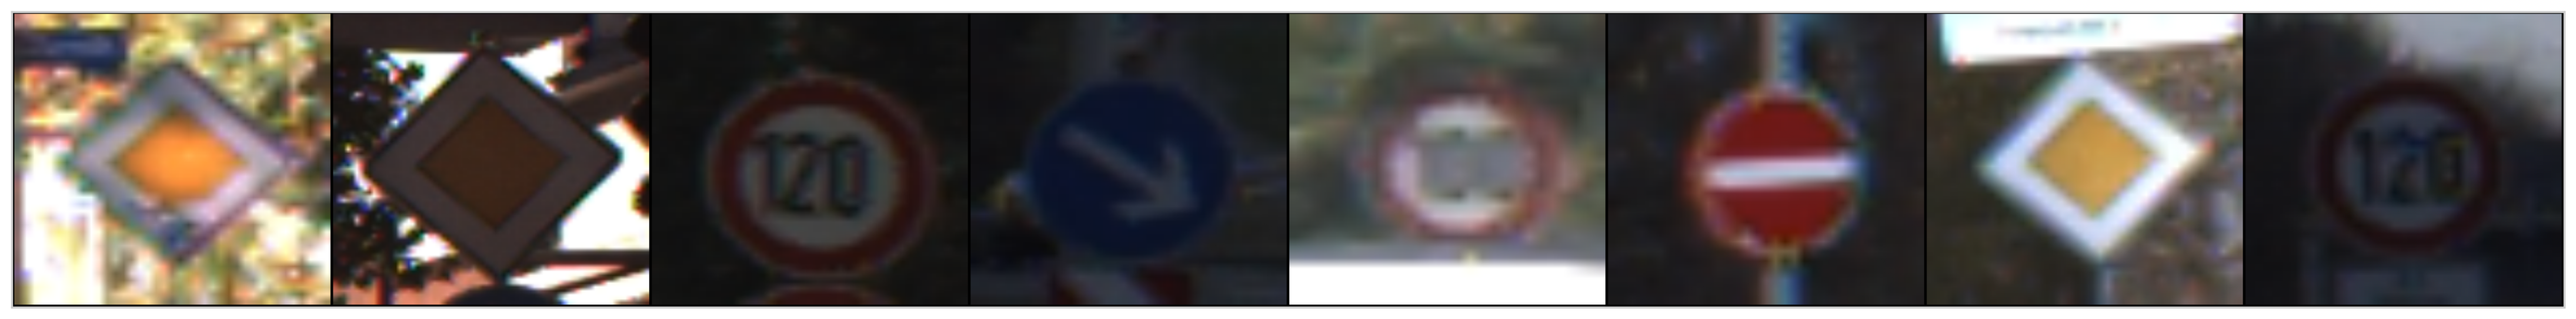

In [9]:
show_batch(train_dl)

In [10]:
import gc
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()

In [41]:
!pip install pynvml

In [11]:
report_gpu()

GPU:0
no processes are running


In [12]:
def create_model(n_classes):
  model = models.resnet50(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [13]:
base_model = create_model(43)

/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # print('correct', correct_predictions, 'n_examples', n_examples, 'preds',len(preds), 'labels',len(labels))
  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [15]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      # print('correct',correct_predictions,'total',n_examples,'outputs',len(outputs),'preds',len(preds),'labels',len(labels))
      losses.append(loss.item())
      # print('correct', correct_predictions,'total',n_examples,'preds',len(preds),'labels',len(labels))
  return correct_predictions.double() / n_examples, np.mean(losses)
     

In [16]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [17]:
print(len(test_dl))

395


In [18]:
data_loaders = {'test': test_dl,'train': train_dl,'val': val_dl}
dataset_sizes = {'test': len(test_dl)*16,'train': len(train_dl)*8,'val': len(val_dl)*16}

In [19]:
dataset_sizes

{'test': 6320, 'train': 21312, 'val': 5328}

In [61]:
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.6636363015471008 accuracy 0.8136730480480481
Val   loss 0.057786246368013196 accuracy 0.9840465465465466

Epoch 2/3
----------
Train loss 0.05230926554676315 accuracy 0.9850788288288288
Val   loss 0.004699363018607163 accuracy 0.9986861861861862

Epoch 3/3
----------
Train loss 0.02382246022082657 accuracy 0.9939470720720721
Val   loss 0.009447801283357392 accuracy 0.99756006006006

Best val accuracy: 0.9986861861861862


In [20]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in tqdm(range(num_epochs), desc = 'Epochs'):
        print(scheduler.get_last_lr())
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloders[phase]):
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                y = torch.nn.functional.one_hot(labels, num_classes = NUM_CATEGORIES).float()
                loss = criterion(outputs, y)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [21]:
def validation_step(model,batch):
    images, labels = batch
    images,labels = images.to(device), labels.to(device)
    out = model(images)
    out =out.to(device)

    loss = F.cross_entropy(out,labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(model,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


In [22]:
@torch.no_grad()

def evaluate(model, val_loader):
  model.eval()
  outputs = [validation_step(model,batch) for batch in tqdm(val_loader)]
  return validation_epoch_end(model,outputs)

def fit (epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): 
  history = []
  optimizer = opt_func(model.parameters(), lr, weight_decay=(lr/epochs),momentum = 0.9)#1e-6
  for epoch in range(epochs):
    if (epoch % 10==0 and epoch > 5):
      optimizer = opt_func(model.parameters(), lr/10, weight_decay=(lr/epochs),momentum = 0.9)#1e-6
    model.train()
    train_losses = []
    #train
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #validate
    result = evaluate(model,val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [23]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [66]:
import torch.nn.functional as F
base_model.eval
result = evaluate(base_model, test_dl)
result

100%|██████████| 395/395 [00:31<00:00, 12.73it/s]


{'val_loss': 0.05650932341814041, 'val_acc': 0.983781635761261}

In [67]:
# torch.save(base_model.state_dict(), 'model_weights.pth')

In [24]:
base_model.load_state_dict(torch.load('model_weights.pth'))
base_model.eval
result = evaluate(base_model, test_dl)
result

100%|██████████| 395/395 [00:31<00:00, 12.57it/s]


{'val_loss': 0.05663042888045311, 'val_acc': 0.9837456345558167}

In [25]:
#function to clamp the values of the image to the range [0,1]
def clamp_image(image):
  return torch.clamp(image, 0, 1)

In [26]:
dic_acc = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: [],
    12: [],
    13: [],
    14: [],
    15: [],
    16: [],
    17: [],
    18: [],
    19: [],
    20: [],
    21: [],
    22: [],
    23: [],
    24: [],
    25: [],
    26: [],
    27: [],
    28: [],
    29: [],
    30: [],
    31: [],
    32: [],
    33: [],
    34: [],
    35: [],
    36: [],
    37: [],
    38: [],
    39: [],
    40: [],
    41: [],
    42: [],
    "mean": []
}

In [27]:
dic_size = {
    36: [],
    42: [],
    64: [],
    "r36": [],
    "r42": [],
    "r64": []
}

In [28]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [29]:
def eval_patch2(model, patch, val_loader, target_class):
    model.eval()
    tp_mean, counter_mean = 0., 0.
    with torch.no_grad():
        for i in tqdm(range(43)):
            counter = 0.
            tp = 0.
            for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
                # For stability, place the patch at 4 random locations per image, and average the performance
                for _ in range(4):
                    patch_img = place_patch(img, patch)
                    patch_img = patch_img.to(device)
                    img_labels = img_labels.to(device)
                    pred = model(patch_img)
                    # In the accuracy calculation, we need to exclude the images that are of our target class
                    # as we would not "fool" the model into predicting those
                    tp += torch.logical_and(torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class),img_labels==i).sum()
                    counter += torch.logical_and((img_labels != target_class),img_labels==i).sum()
            acc = tp/counter
            dic_acc[i].append(acc.item())
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
                # For stability, place the patch at 4 random locations per image, and average the performance
                for _ in range(4):
                    patch_img = place_patch(img, patch)
                    patch_img = patch_img.to(device)
                    img_labels = img_labels.to(device)
                    pred = model(patch_img)
                    tp_mean += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                    counter_mean += (img_labels != target_class).sum()
        acc_mean = tp_mean/counter_mean
        dic_acc["mean"].append(acc_mean.item())


In [30]:
std=[]
def eval_std():
    for i in tqdm(range(43)):
        dic_size[36].append(dic_acc[i][0])
        dic_size[42].append(dic_acc[i][1])
        dic_size[64].append(dic_acc[i][2])
        dic_size["r36"].append(dic_acc[i][3])
        dic_size["r42"].append(dic_acc[i][4])
        dic_size["r64"].append(dic_acc[i][5])
    for i in [36,42,64,"r36","r42","r64"]:
        std.append(np.nanstd(dic_size[i]))

    

In [31]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [34]:
# TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]

def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    # patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    # clip patch values from [-infty,infty] to [0,1]
    patch = torch.clamp(patch, min=0.0, max=1.0)

    return patch

In [35]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_loader = train_dl
    val_loader = val_dl

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.ones(3, patch_size[0], patch_size[1]).fill_(.5), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    patch = patch_forward(patch)
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [ ]:
patch_size = 64
patch64, val_results64 = patch_attack(base_model , target_class=8, patch_size=patch_size, num_epochs=700)
torch.save(patch64, 'patch64.pt')
patch_size = 42
patch42, val_results42 = patch_attack(base_model , target_class=8, patch_size=patch_size, num_epochs=700)
torch.save(patch42, 'patch42.pt')
patch_size = 36
patch36, val_results36 = patch_attack(base_model , target_class=8, patch_size=patch_size, num_epochs=700)
torch.save(patch36, 'patch36.pt')

In [92]:
# torch.save(dic_acc, 'dic_acc.pt')
# torch.save(dic_size, 'dic_size.pt')
# torch.save(patch64, 'patch64_2.pt')
# torch.save(patch42, 'patch42_2.pt')
# torch.save(patch36, 'patch36_2.pt')

In [ ]:
plt.imshow(np.transpose(patch64, [1,2,0]))
print(torch.min(patch64), torch.max(patch64))
# print(patch64)
print(val_results64)
# plt.imshow(np.transpose(patch42, [1,2,0]))
print(torch.min(patch42),torch.max(patch42))
print(val_results42)
# plt.imshow(np.transpose(patch36, [1,2,0]))
print(torch.min(patch36),torch.max(patch36))
print(val_results36)


In [97]:
acc, top5 = eval_patch(base_model, patch64, test_dl, target_class=8)
print(f"Accuracy: {acc.item():4.2f}, Top-5: {top5.item():4.2f}")

Accuracy: 0.72, Top-5: 0.96


In [126]:
#create a random patch with size patch_size with valuesl between 0 and 1
patch_size = 64
random_patch = torch.rand(3, patch_size, patch_size)
acc_rand, top5_rand = eval_patch(base_model, random_patch, test_dl, target_class=8)

In [ ]:
eval_patch2(base_model, patch36, test_dl, target_class=8)

In [66]:
print(dic_acc)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 'mean': []}


In [ ]:
random_patch_36 = torch.rand(3, 36, 36)
random_patch_42 = torch.rand(3, 42, 42)
random_patch_64 = torch.rand(3, 64, 64)
eval_patch2(base_model, patch36, test_dl, target_class=8)
eval_patch2(base_model, patch42, test_dl, target_class=8)
eval_patch2(base_model, patch64, test_dl, target_class=8)
eval_patch2(base_model, random_patch_36, test_dl, target_class=8)
eval_patch2(base_model, random_patch_42, test_dl, target_class=8)
eval_patch2(base_model, random_patch_64, test_dl, target_class=8)



In [ ]:
print(dic_size)

In [ ]:
eval_std()
print(std)

In [37]:
#load the patches
patch64 = torch.load('patch64_2.pt')
patch42 = torch.load('patch42_2.pt')
patch36 = torch.load('patch36_2.pt')


In [38]:
classes_dic = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }
lbls= [classes_dic[i] for i in range(43)]

In [88]:
def show_prediction2(img, label, pred, K=5, adv_img=None, noise=None, target=8,patch_size="",num="",save=False):
    print(label)
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        # img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(17,3), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(16,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(classes_dic[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        # adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    print(topk_idx)
    color = []
    for i in range(K):
        if topk_idx[i] == label:
            color.append('green')
        elif topk_idx[i] == target:
            color.append('red')
        else:
            color.append('blue')
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=color)
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([classes_dic[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    if save:
        plt.savefig("./results2/imgs/"+patch_size+'/'+str(label)+'/'+patch_size+'_'+str(label)+'_8_'+num+'.pdf', format='pdf')
    plt.show()
    
    plt.close()

In [ ]:
exmp_batch, label_batch = next(iter(test_dl))
with torch.no_grad():
    preds = base_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction2(exmp_batch[i], label_batch[i], preds[i])

In [91]:
def perform_patch_attack(patch):
    for x in range(30,43):
        if x == 8:
            continue
        num_success = 0
        print(x)
        while num_success < 4:
            patch_batch, label_batch = next(iter(test_dl))
            patch_batch = place_patch(patch_batch, patch)
            with torch.no_grad():
                patch_preds = base_model(patch_batch.to(device))
            for i in range(len(patch_batch)):
                if patch_preds[i].argmax() != label_batch[i] and label_batch[i] == x and patch_preds[i].argmax() == 8:
                    show_prediction2(patch_batch[i], label_batch[i], patch_preds[i], num=str(num_success), save=True, patch_size=str(patch.shape[1]),target=8)
                    num_success += 1
                if num_success >= 4:
                    break

In [ ]:
perform_patch_attack(patch36)

In [93]:
def show_prediction_random(img, label, pred, K=5, adv_img=None, noise=None, patch_size="",num="",save=False):
    print(label)
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        # img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(17,3), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(16,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(classes_dic[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        # adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    print(topk_idx)
    color = []
    for i in range(K):
        if topk_idx[i] == label:
            color.append('green')
        else:
            color.append('blue')
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=color)
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([classes_dic[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    if save:
        plt.savefig("./results2/imgs/"+patch_size+'/'+str(label)+'/'+patch_size+'_'+str(label)+'_'+num+'.pdf', format='pdf')
    plt.show()
    plt.close()

In [123]:
def perform_patch_attack(patch):
    for x in range(33,43):
        if x == 8:
            continue
        num_success = 0
        print(x)
        while num_success < 4:
            patch_batch, label_batch = next(iter(test_dl))
            if x in label_batch:
                patch_batch = place_patch(patch_batch, patch)
                with torch.no_grad():
                    patch_preds = base_model(patch_batch.to(device))
                for i in range(len(patch_batch)):
                    if patch_preds[i].argmax() != label_batch[i] and label_batch[i] == x and patch_preds[i].argmax() == 8:
                        show_prediction2(patch_batch[i], label_batch[i], patch_preds[i], num=str(num_success), save=True, patch_size=str(patch.shape[1]),target=8)
                        num_success += 1
                    if num_success >= 4:
                        break
            else:
                continue

In [ ]:
perform_patch_attack(patch42)

In [ ]:
perform_patch_attack(patch64)

In [115]:
def perform_patch_attack_random(patch):
    for x in range(32,43):

        num_success = 0
        print(x)
        while num_success < 4:
            
            patch_batch, label_batch = next(iter(test_dl))
            if x in label_batch:
                patch_batch = place_patch(patch_batch, patch)
                with torch.no_grad():
                    patch_preds = base_model(patch_batch.to(device))
                for i in range(len(patch_batch)):
                    if label_batch[i] == x and patch_preds[i].argmax() == label_batch[i]:
                        show_prediction_random(patch_batch[i], label_batch[i], patch_preds[i], num=str(num_success), save=True, patch_size='random'+str(patch.shape[1]))
                        num_success += 1
                    if num_success >= 4:
                        break
            else:
                continue

In [ ]:
perform_patch_attack_random(random_patch_36)

In [ ]:
perform_patch_attack_random(random_patch_42)

In [ ]:
perform_patch_attack_random(random_patch_64)

In [102]:
def show_prediction_normal(img, label, pred, K=5, adv_img=None, noise=None,num="",save=False):
    print(label)
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        # img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(17,3), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(16,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(classes_dic[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        # adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    print(topk_idx)
    color = []
    for i in range(K):
        if topk_idx[i] == label:
            color.append('green')
        else:
            color.append('blue')
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=color)
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([classes_dic[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    if save:
        plt.savefig('./results2/imgs/normal/'+str(label)+'/'+str(label)+'_'+num+'.pdf', format='pdf')
    plt.show()
    plt.close()

In [101]:
def perform_no_attack():
    for x in range(43):
        num_success = 0
        print(x)
        while num_success < 4:
            patch_batch, label_batch = next(iter(test_dl))
            if x in label_batch:
                with torch.no_grad():
                    patch_preds = base_model(patch_batch.to(device))
                for i in range(len(patch_batch)):
                    if label_batch[i] == x and patch_preds[i].argmax() == x:
                        show_prediction_normal(patch_batch[i], label_batch[i], patch_preds[i], num=str(num_success), save=True)
                        num_success += 1
                    if num_success >= 4:
                        break
            else:
                continue

In [ ]:
perform_no_attack()

In [163]:
import csv
val_res_total = [[val_res_32['acc'],val_res_32['top5']],[val_res_48['acc'],val_res_48['top5']],[val_res_64['acc'],val_res_64['top5'],]]
print(val_res_total)
#write the results to a csv file
with open('./result_values.csv', 'w') as f:
    writer = csv.writer(f)
    for row in val_res_total:
       writer.writerow(row)
#save the csv



[[0.011390186846256256, 0.23914524912834167], [0.5203952789306641, 0.8519762754440308], [0.8954439163208008, 0.9926012754440308]]


In [162]:
#open the csv file and read the results
with open('./result_values.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)


['0.011390186846256256', '0.23914524912834167']
['0.5203952789306641', '0.8519762754440308']
['0.8954439163208008', '0.9926012754440308']


In [171]:

#save the generated patch permute the dimensions to match the input image solving the error TypeError: Cannot interpret 'torch.float32' as a data type
patch2 = patch.permute(1,2,0)
torch.save(patch2, './patch.pt')




In [173]:
#print the curretn directory
print(os.getcwd())

/home/roberto/Desktop/tfg/patch


In [ ]:
print(patch_64)

In [ ]:
import csv
asr=[]
top5=[]

with open('result_values.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        asr.append(float(row[0]))
        top5.append(float(row[1]))

print(asr)
print(top5)

In [144]:
def plot_accuracies(acc,top5,save=''):
    aux = [r'$32$',r'$48$',r'$64$']#
    fig, ax = plt.subplots()


    ax.plot(range(3),acc,label='Top 99',color='blue')
    ax.set_xlabel(r'$Patch size$')
    # ax.xlabel(r'$C$')
    ax.set_xticks(range(3),aux)
    ax.set_ylabel('Attack Success Rate')
    ax.plot(range(3),top5,label='Top 5',color='green')

    # ax2 = ax.twinx()
    # ax2.plot(range(3),top5,color='green')
    # ax2.set_ylabel('Top5 Attack Success Rate',color='green')

    # plt.title('Attack Success Rate vs. ' r'$C$')
    plt.legend()
    plt.yticks(np.arange(0, 1.1, step=0.1))
    if save!="":
      plt.savefig('C&W_L2_'+save+'.pdf',format='pdf',bbox_inches='tight')
    plt.show()

In [ ]:
plot_accuracies(random_acc,random_top5,save='ASR_random_patch')

In [157]:
def plot_accuracies_percentage(save = False):
  for i in range (43):
    aux = [r'15%',r'20%',r'30%']#
    fig, ax = plt.subplots()


    ax.plot(range(3),dic_acc[i][:3],label='Class'+str(i),color='green')
    ax.set_xlabel(r'$Patch size$')
    # ax.xlabel(r'$C$')
    ax.set_xticks(range(3),aux)
    
    ax.set_ylabel('Attack Success Rate')
    ax.plot(range(3),dic_acc[i][3:],label='Random',color='red')
    ax.errorbar(range(3),dic_acc["mean"][:3],yerr=std[:3],label='Mean',color='blue', linestyle = "dashdot", capsize=3)
    ax.errorbar(range(3),dic_acc["mean"][3:],yerr=std[3:],label='Mean Random',color='orange', linestyle = "dashdot", capsize=3)

    # ax2 = ax.twinx()
    # ax2.plot(range(3),top5,color='green')
    # ax2.set_ylabel('Top5 Attack Success Rate',color='green')

    # plt.title('Attack Success Rate vs. ' r'$C$')
    plt.legend()
    plt.yticks(np.arange(0, 1.1, step=0.1))
    if save==True:
      plt.savefig('class'+str(i)+'_real_imgs'+'.pdf',format='pdf',bbox_inches='tight')
    plt.show()

In [ ]:
plot_accuracies_percentage(save=True)